#https://www.tensorflow.org/tutorials/keras/basic_text_classification

Tập dữ liệu [imdb](https://storage.googleapis.com/tensorflow/tf-keras-datasets/imdb.npz
) gồm nội dung 50000 comments từ các bộ phim trên internet. Trong đó 25000 được chia thành tập training và 25000 được chia thành tập testing. Các comments được phân thành 2 loại là tiêu cực và tích cực. Các tập training và testing có tỷ lệ comment cân bằng giữa tập tiêu cực và tích cực. Ta sẽ cần xây dựng model phân loại chính xác các comment theo đúng nhóm tiêu cực hoặc tích cực.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.10.0


In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 6s 0us/step

In [3]:
print("Length train: {}; Length test: {}".format(len(train_data), len(test_data)))

Length train: 25000; Length test: 25000


In [6]:
print("Head train data: {}; Head train labels: {}".format(train_data[:1], train_labels[:1]))

Head train data: [list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])]; Head train labels: [1]


In [60]:
print("Number of words in first comments: {}; second comments: {}".format(len(train_data[0]), len(train_data[1])))

Number of words in first comments: 256; second comments: 256


Mỗi list trong train_data là một tập hợp các từ trong cùng 1 comment đã được mã hóa dưới dạng số. Giá trị của số chính là thứ tự của từ trong dictionary gồm toàn bộ các từ được comments. 

Tiếp theo ta sẽ chuyển các số tự nhiên về chữ cái thông qua một hàm chứa số thứ tự để map các kí tự.

In [64]:
import numpy as np

# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

#Print the maximun index of word
print('Maximun index of word: {}'.format(np.max([v for k, v in word_index.items()])))


# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

Maximun index of word: 88584


In [47]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

Các comments (đã được mã hóa dưới dạng các số nguyên) cần phải được chuyển về tensors trước khi đưa vào mạng nơ ron. Có 2 cách chuyển dữ liệu:

* Chuyển chúng về các onehot vector có giá trị 0,1. Chẳng hạn list [3, 5] sẽ là một vector có vị trí thứ 3 và 5 là 1 và các vị trí còn lại bằng 0. Như vậy chúng ta cần một ma trận có kích thước = `num_words x num_comments`. Có thể sử dụng Dense layer để khởi tạo layer đầu tiên - layer này có thể kiểm soát các phần tử float.

* Một cách khác ta có thể đưa các mảng về cùng một độ dài (pad array) và tạo thành các tensors có kích thước = `max_length x num_comments`. Và có thể sử dụng embedding layer để quản lý hình dạng của layer đầu tiên.

Trong bài này ta sẽ theo cách 2.

In [58]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

Bây giờ tất các các comments đều có cùng độ dài.

In [61]:
len(train_data[0]), len(train_data[1])

(256, 256)

Kiểm tra comment đầu tiên.

In [62]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

# Xây dựng mô hình

Mô hình mạng nơ ron được tạo ra bởi những layer chồng nhau và cần phải quyết định:

* Số lượng layers.
* Số lượng các units trong mỗi layer.

Bên dưới là cấu trúc của model phân loại nội dung comments.

In [63]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).
2. Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
4. The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

In [65]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [66]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

(25000, 256)

# Train model

Train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the x_train and y_train tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [69]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 5s 334us/step - loss: 0.6927 - acc: 0.5183 - val_loss: 0.6897 - val_acc: 0.5492

# Đánh giá model

In [73]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 48us/step

Đây là một cách tiếp cận khá cơ bản và mức độ chính xác đạt được là 87%. Một số cách tiếp cận nâng cao hơn có thể đạt kết quả lên tới 95%.

# Tạo đồ thị đánh giá Accuracy và loss qua thời gian

model.fit() returns a History object that contains a dictionary with everything that happened during training:

In [70]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

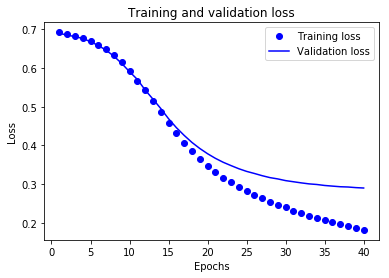

In [71]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

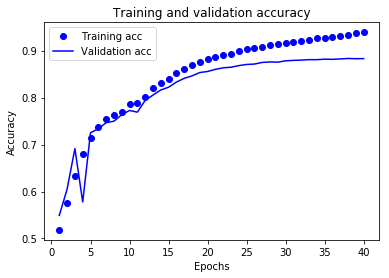

In [74]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()